In [1]:
import numpy as np
import pandas as pd
import os
import sys
import torch
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import optuna
import random
import joblib
from config import results_dir, images_dir, data_dir

print(f"Results will be saved in: {results_dir}")
print(f"Images will be saved in: {images_dir}")
print(f"Data will be accessed from: {data_dir}")

os.makedirs(results_dir, exist_ok=True)

if '__file__' in globals():
    # For standalone scripts
    base_dir = os.path.dirname(__file__)
else:
    # For Jupyter or interactive environments
    base_dir = os.getcwd()

# Add the parent directory of `utils` to the Python path
sys.path.append(os.path.abspath(os.path.join(base_dir, "../")))

In [2]:
# Import shared setup
from utils.setup import seed, device, early_stopper, pipeline, test_tensor

# Example usage
print(f"Device: {device}")
test_tensor()

tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691],
        [0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938],
        [0.6128, 0.1519, 0.0453]])


In [3]:
#load data 
n = 100000 #number of data points
k = 3 #number of variables
p = 5 # pattern length
variable_indexes = np.arange(k)
variables_pattern = [0,2]

dataset_path = os.path.join(data_dir, "scenario1_n={}_k={}_p={}_min_step={}_max_step={}_variables={}.csv".format(n, k, p, 5, 45, variables_pattern))
motif_indexes_path = os.path.join(data_dir, "motif_indexes_scenario1_n={}_k={}_p={}_min_step={}_max_step={}.csv".format(n, k, p, 5, 45))
data = np.genfromtxt(dataset_path, delimiter=",").astype(int).reshape((k, n))
motif_indexes = np.genfromtxt(motif_indexes_path, delimiter=",").astype(int)

print(motif_indexes)


[    0    10    22 ... 99922 99956 99992]


TRAIN: [    0     1     2 ... 15997 15998 15999] TEST: [16000 16001 16002 ... 19997 19998 19999]
TRAIN: [20000 20001 20002 ... 35997 35998 35999] TEST: [36000 36001 36002 ... 39997 39998 39999]
TRAIN: [40000 40001 40002 ... 55997 55998 55999] TEST: [56000 56001 56002 ... 59997 59998 59999]
TRAIN: [60000 60001 60002 ... 75997 75998 75999] TEST: [76000 76001 76002 ... 79997 79998 79999]
TRAIN: [80000 80001 80002 ... 95997 95998 95999] TEST: [96000 96001 96002 ... 99997 99998 99999]


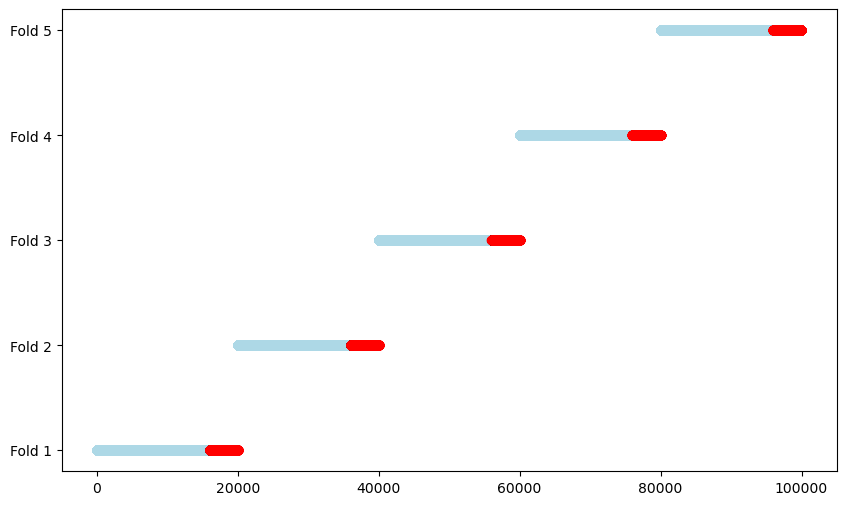

In [4]:
from utils.timeseries_split import BlockingTimeSeriesSplit

#create index  
indexes = np.arange(len(data[0]))

#split data
tscv = BlockingTimeSeriesSplit(n_splits=5)
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(indexes)):
    # Plot train and test indices
    ax.plot(train_index, np.zeros_like(train_index) + i, 'o', color='lightblue')
    ax.plot(test_index, np.zeros_like(test_index) + i, 'o', color='red')
    print("TRAIN:", train_index, "TEST:", test_index)
    

ax.set_yticks(np.arange(5), ["Fold {}".format(i) for i in range(1, 6)])
plt.show()

In [5]:
from utils.utils import create_dataset

lookback_period = 100 #window size
step = 5 #step size for the sliding window
forecast_period = 50 #forward window size

#x1: past window, x2: indexes of the motif in the window,  y: next relative index of the motif
X1, X2, y = create_dataset(data, variable_indexes, lookback_period, step, forecast_period, motif_indexes)

# X1, X2, and y are now PyTorch tensors
print("X1 shape:", X1.shape)  # Expected shape: (num_samples, lookback_period, num_features)
print("X2 shape:", X2.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
print("y shape:", y.shape)    # Expected shape: (num_samples, 1)


X1 shape: torch.Size([19979, 100, 3])
X2 shape: torch.Size([19979, 6, 1])
y shape: torch.Size([19979, 1])


In [6]:
from models.informer_pytorch import Informer
from utils.train_pipeline import run_optuna_study
from utils.utils import print_study_results, plot_best_model_results

n_trials = 100
num_epochs = 500
model_type = "Informer"
model_name = "InformerSeries"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3],
        "kwargs": {"log": True}
    },
    "d_model": {
        "type": "categorical",
        "args": [[64, 128, 256, 512]]
    },
    "n_heads": {
        "type": "categorical",
        "args": [[1, 2, 4, 8, 16]]
    },
    "attn": {
        "type": "categorical",
        "args": [["prob", "full"]]
    },
    "e_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]
    },
    "d_layers": {
        "type": "categorical",
        "args": [[1, 2]]
    },
    "dropout": {
        "type": "float",
        "args": [0.0, 0.5]
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]]
    }
}

model_params_keys = ["n_heads", "d_model", "attn", "e_layers", "d_layers", "dropout"]


result_dir = os.path.join(results_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(result_dir, exist_ok=True)

run_optuna_study(pipeline.run_cross_val, Informer, model_type, suggestion_dict, model_params_keys, seed, X1, None, y, result_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(result_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(
    study.trials_dataframe(),
    save_path=os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png")
)

[I 2024-12-20 14:53:15,825] A new study created in memory with name: no-name-198aae6e-9179-4d46-b901-29abc540ecfd


Early stopping at epoch 117, with best epoch being 88
Early stopping at epoch 113, with best epoch being 85
Early stopping at epoch 115, with best epoch being 104
Early stopping at epoch 129, with best epoch being 118


[I 2024-12-20 15:17:03,591] Trial 0 finished with value: 108.98028259277343 and parameters: {'learning_rate': 2.6565450821928437e-05, 'd_model': 256, 'n_heads': 3, 'attn': 'prob', 'e_layers': 2, 'd_layers': 2, 'dropout': 0.25599658869775177, 'batch_size': 16}. Best is trial 0 with value: 108.98028259277343.


Early stopping at epoch 113, with best epoch being 102


[W 2024-12-20 15:17:30,697] Trial 1 failed with parameters: {'learning_rate': 4.946096107589924e-05, 'd_model': 64, 'n_heads': 7, 'attn': 'prob', 'e_layers': 1, 'd_layers': 2, 'dropout': 0.42903854381849826, 'batch_size': 32} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/mgsilva/miniconda3/envs/torch_motifpredenv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/home/mgsilva/motifpred/code/utils/train_pipeline.py", line 89, in objective
    trial_val_loss, _, _ = objective_func(trial, seed, results_folder, model_class, model_type, X1, y, X2, criterion, num_epochs, hyperparameters, model_params_keys)  # Pass hyperparameters
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mgsilva/motifpred/code/ut

KeyboardInterrupt: 

In [6]:
from models.informer_pytorch import Informer
from utils.utils import print_study_results, plot_best_model_results

n_trials = 100
num_epochs = 500
model_type = "Informer"
model_name = "InformerSeries_X2Masking"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3],
        "kwargs": {"log": True}
    },
    "d_model": {
        "type": "categorical",
        "args": [[64, 128, 256, 512]]
    },
    "n_heads": {
        "type": "categorical",
        "args": [[1, 2, 4, 8, 16]]
    },
    "attn": {
        "type": "categorical",
        "args": [["prob", "full"]]
    },
    "e_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]
    },
    "s_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]
    },
    "dropout": {
        "type": "float",
        "args": [0.0, 0.5]
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]]
    }
}

model_params_keys = ["n_heads", "d_model", "attn", "e_layers", "s_layers", "dropout"]

#X1 shape is (num_samples, lookback_period)
masking_X1 = np.zeros((X1.shape[0], X1.shape[1])) 

for i, obs_motif_indexes in enumerate(X2):
    for j, idx in enumerate(obs_motif_indexes):
        masking_X1[i, idx.item():idx.item()+p] = 1

masking_X1 = torch.tensor(masking_X1, dtype=torch.float32)

result_dir = os.path.join(results_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(result_dir, exist_ok=True)

run_optuna_study(pipeline.run_cross_val, Informer, model_type, suggestion_dict, model_params_keys, seed, X1, masking_X1, y, result_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(result_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(
    study.trials_dataframe(),
    save_path=os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png")
)

[I 2024-12-18 19:25:05,996] A new study created in memory with name: no-name-96cb2360-59d4-4609-b5d0-0a3cac7499e8
[W 2024-12-18 19:25:14,332] Trial 0 failed with parameters: {'learning_rate': 2.6565450821928437e-05, 'kernel_size': 7, 'num_blocks': 5, 'dropout': 0.12704166510234777, 'batch_size': 16, 'block_channels_0': 16, 'block_channels_1': 32, 'block_channels_2': 32, 'block_channels_3': 16, 'block_channels_4': 16} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/mgsilva/miniconda3/envs/torch_motifpredenv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/home/mgsilva/motifpred/code/utils/train_pipeline.py", line 88, in objective
    trial_val_loss, _, _ = objective_func(trial, seed, results_folder, model_class, model_type, X1, y, X2, criterion, num_epochs, hyperparameters, model_params_keys)  # Pass hyperparameters
          

KeyboardInterrupt: 

In [ ]:
# from utils.utils import plot_preds_vs_truevalues
# from utils.train_pipeline import get_preds_best_config


# epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, CNNX1_X2Masking, model_type, model_params_keys, num_epochs =num_epochs, seed=seed, X1=X1, X2=masking_X1, y=y)

# # Plot the train and validation losses for each fold
# fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
# for i in range(5):
#     axes[i].plot(epochs_train_losses[i], label="Train Loss")
#     axes[i].plot(epochs_val_losses[i], label="Validation Loss")
#     axes[i].set_title(f"Fold {i + 1}")
#     axes[i].set_xlabel("Epoch")
#     if i == 0:
#         axes[i].set_ylabel("Loss")
#     axes[i].legend()

# plt.tight_layout()
# plt.savefig(os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
# plt.show()

# # Plot the predictions vs true values for each fold
# for fold in range(5):
#     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))


for fold in range(5):
    img = mpimg.imread(os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')  # Hide axes for a cleaner display
    plt.show()
